# RNN - Many-to-many bidirectional

> In this post, We will extend the many-to-many RNN model with bidirectional version. And it will show the simple implementation in tensorflow.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Deep_Learning, Tensorflow-Keras]
- image: images/rnn_bidirectional.png

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print('Tensorflow: {}'.format(tf.__version__))

plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

Tensorflow: 2.3.1


> Note: There may some errors while using rnn layer in tensorflow 2.1.x. Usually, it will show the debug message like `CUDNN_STATUS_INTERNAL_ERROR`. See the details from [here](https://github.com/tensorflow/tensorflow/issues/24496). To prevent this, we need to set gpu configuration.

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## What is "bidirectional"?

![rnn-bidirectional](image/rnn_many-to-many-bidirectional.png)

In previous post, we learned (basic) many-to-many rnn model, and implemented it for Part-of-Speech (POS) Tagging.

As we already know, the input is sequential data and hidden node is connected sequentially. That is, information contained in each node may be different. For example, assume that first token is consumed in first hidden node, and the information (maybe state information) will be transfered to the next hidden node, and so on. This process is repeated, and at last, the last hidden node will containe lots of information compared with previous node's. In that case, there is imbalance in the amount of information seen by the hidden states at different time steps.

So how can we prevent this? One approach is to add another hidden layer for information balance. So the information obtained from last token will be propagated to first hidden node. As a result, there are two kinds of hidden layer: the forward-pass, and the backward-pass. That's why we call this kind of model to **"Bidirectional"**.

![rnn-bidirectional2](image/rnn_bidirectional.png)

The detailed representation is like this. There are two hidden layers, forward rnn and backward rnn. At each time step, the hidden node from forward rnn and the hidden node from backward rnn is concatenated. Then, it will multiply with weight of node, and adding the bias. After that, output is generated.

Since this model is also many-to-many rnn model, the sequence loss is used.

## Example - Part-of-Speech tagging

Like the previous example, we will implement the bidirectional model for POS tagging. 

### Prepare dataset

In [29]:
sentences = [['I', 'feel', 'hungry'],
             ['tensorflow', 'is', 'very', 'difficult'],
             ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
             ['tensorflow', 'is', 'very', 'fast', 'changing']]

pos = [['pronoun', 'verb', 'adjective'], 
       ['noun', 'verb', 'adverb', 'adjective'],
       ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
       ['noun', 'verb', 'adverb', 'adjective', 'verb']]

### Preprocess data

In [30]:
word_list = ['<pad>'] + sorted(set(sum(sentences, [])))
word2idx = {word:idx for idx, word in enumerate(word_list)}
idx2word = {idx:word for idx, word in enumerate(word_list)}

In [31]:
print(word2idx)

{'<pad>': 0, 'I': 1, 'a': 2, 'changing': 3, 'deep': 4, 'difficult': 5, 'fast': 6, 'feel': 7, 'for': 8, 'framework': 9, 'hungry': 10, 'is': 11, 'learning': 12, 'tensorflow': 13, 'very': 14}


In [32]:
print(idx2word)

{0: '<pad>', 1: 'I', 2: 'a', 3: 'changing', 4: 'deep', 5: 'difficult', 6: 'fast', 7: 'feel', 8: 'for', 9: 'framework', 10: 'hungry', 11: 'is', 12: 'learning', 13: 'tensorflow', 14: 'very'}


In [33]:
pos_list = ['<pad>'] + sorted(set(sum(pos, [])))
pos2idx = {pos:idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx:pos for idx, pos in enumerate(pos_list)}

In [34]:
print(pos2idx)

{'<pad>': 0, 'adjective': 1, 'adverb': 2, 'determiner': 3, 'noun': 4, 'preposition': 5, 'pronoun': 6, 'verb': 7}


In [35]:
print(idx2pos)

{0: '<pad>', 1: 'adjective', 2: 'adverb', 3: 'determiner', 4: 'noun', 5: 'preposition', 6: 'pronoun', 7: 'verb'}


Same as before, we build the token/POS dictionary. And we need to consider padding token. So we make a masking vector for filtering padding token.

In [36]:
X = list(map(lambda sentence: [word2idx.get(token) for token in sentence], sentences))
y = list(map(lambda sentence: [pos2idx.get(token) for token in sentence], pos))

print(X)
print(y)

[[1, 7, 10], [13, 11, 14, 5], [13, 11, 2, 9, 8, 4, 12], [13, 11, 14, 6, 3]]
[[6, 7, 1], [4, 7, 2, 1], [4, 7, 3, 4, 5, 1, 4], [4, 7, 2, 1, 7]]


In [37]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = pad_sequences(X, maxlen=10, padding='post')
X_mask = (X != 0).astype(np.float32)
X_len = np.array(list((map(lambda sentence: len(sentence), sentences))), dtype=np.float32)

print(X)
print(X_mask)
print(X_len)

[[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]]
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]
[3. 4. 7. 5.]


In [38]:
y = pad_sequences(y, maxlen=10, padding='post')

print(y)

[[6 7 1 0 0 0 0 0 0 0]
 [4 7 2 1 0 0 0 0 0 0]
 [4 7 3 4 5 1 4 0 0 0]
 [4 7 2 1 7 0 0 0 0 0]]


In [39]:
train_ds = tf.data.Dataset.from_tensor_slices((X, y, X_len)).shuffle(buffer_size=4).batch(batch_size=2)
print(train_ds)

<BatchDataset shapes: ((None, 10), (None, 10), (None,)), types: (tf.int32, tf.int32, tf.float32)>


### Model implementation

Here, we will use new kind of layer, [`Bidirectional`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Technically, it is not operational layer, like `Dense`, `Conv2D`, `Flatten`, and so on. It is wrapper for rnn layers. So it requires base rnn layer, like `SimpleRNN`, `LSTM`, and `GRU`.

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Embedding, Bidirectional, SimpleRNN, TimeDistributed, Dense


num_classes = len(pos2idx)

input_dim = len(word2idx)
output_dim = len(word2idx)

model = Sequential([
    InputLayer(input_shape=(10, )),
    Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True,
              trainable=False, input_length=10, 
              embeddings_initializer=tf.keras.initializers.random_normal()),
    Bidirectional(SimpleRNN(units=10, return_sequences=True)),
    TimeDistributed(Dense(units=num_classes))
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 15)            225       
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 20)            520       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 8)             168       
Total params: 913
Trainable params: 688
Non-trainable params: 225
_________________________________________________________________


### Model training

After that, we can define loss function (same as previous example in many-to-many post) and optimizer (we will use Adam optimizer)

In [40]:
def loss_fn(model, x, y, x_len, max_sequence):
    masking = tf.sequence_mask(x_len, maxlen=max_sequence, dtype=tf.float32)
    sequence_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x), from_logits=True) * masking
    sequence_loss = tf.reduce_mean(tf.reduce_sum(sequence_loss, axis=-1) / x_len)
    return sequence_loss

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

In [41]:
tr_loss_hist = []

for e in range(30):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb, x_mb_len in train_ds:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x_mb, y_mb, x_mb_len, 10)
        grads = tape.gradient(target=tr_loss, sources=model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.trainable_variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    if (e + 1) % 5 == 0:
        print('Epoch: {:3}, tr_loss: {:.3f}'.format(e + 1, avg_tr_loss))

Epoch:   5, tr_loss: 0.256
Epoch:  10, tr_loss: 0.016
Epoch:  15, tr_loss: 0.002
Epoch:  20, tr_loss: 0.001
Epoch:  25, tr_loss: 0.001
Epoch:  30, tr_loss: 0.000


Compared with the result from basic many-to-many model, training loss is slightly decreased.
Then, let's check the performance.

In [42]:
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=-1) * X_mask

y_pred

array([[6., 7., 1., 0., 0., 0., 0., 0., 0., 0.],
       [4., 7., 2., 1., 0., 0., 0., 0., 0., 0.],
       [4., 7., 3., 4., 5., 1., 4., 0., 0., 0.],
       [4., 7., 2., 1., 7., 0., 0., 0., 0., 0.]])

In [43]:
from pprint import pprint

y_pred_pos = list(map(lambda row: [idx2pos.get(elm) for elm in row], y_pred.astype(np.int32).tolist()))

pprint(y_pred_pos)

pprint(pos)

[['pronoun',
  'verb',
  'adjective',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['noun',
  'verb',
  'adverb',
  'adjective',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['noun',
  'verb',
  'determiner',
  'noun',
  'preposition',
  'adjective',
  'noun',
  '<pad>',
  '<pad>',
  '<pad>'],
 ['noun',
  'verb',
  'adverb',
  'adjective',
  'verb',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>',
  '<pad>']]
[['pronoun', 'verb', 'adjective'],
 ['noun', 'verb', 'adverb', 'adjective'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb']]


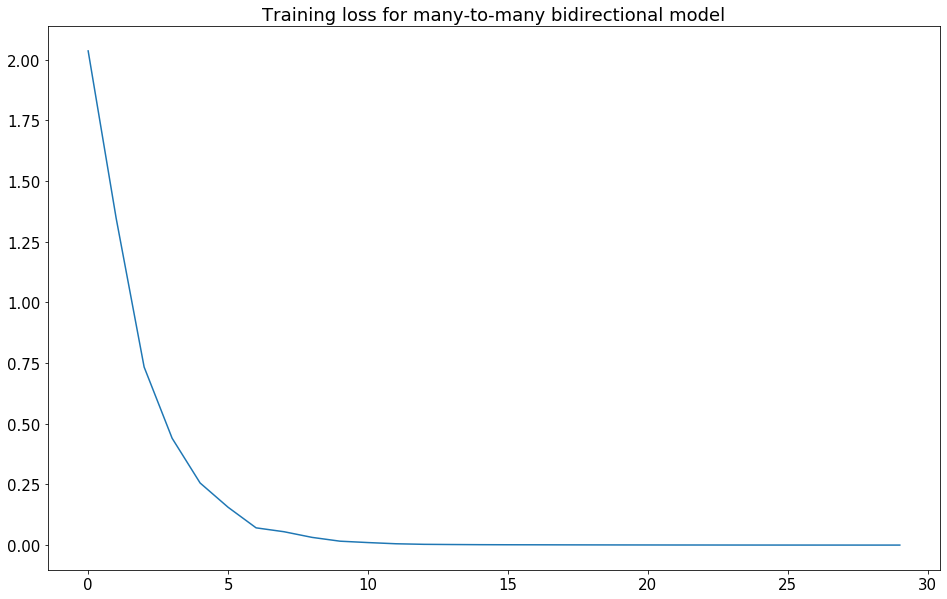

In [44]:
plt.figure()
plt.plot(tr_loss_hist)
plt.title('Training loss for many-to-many bidirectional model')
plt.show()

## Summary

Through this post, in order to handle the information imbalance while processing sequence data, another rnn layer is added. So the information is transfered in 2 ways (forward-pass and backward-pass). 

we try to implement this kind of bidirectional many-to-many model with tensorflow, and train it for POS tagging. Interestingly, the training speed is slightly faster than base model, and it also show 100% accuracy on training dataset.